<a href="https://colab.research.google.com/github/edwin-19/nemo_example/blob/master/Nemo_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg
!pip install Cython
!pip install datasets
!pip install jiwer

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [954 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [734 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [731 kB]
Fetched 2,756 kB in 2s (1,296 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Read

In [2]:
## Install NeMo
BRANCH = 'main'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-rwcyeuj4/nemo-toolkit_05ddddaa89ad4020b3203e54b4de094b
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-rwcyeuj4/nemo-toolkit_05ddddaa89ad4020b3203e54b4de094b
  Resolved https://github.com/NVIDIA/NeMo.git to commit 00eeb29dd9e1cf7a0b1bbc0d64bd14143453eabe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8

In [4]:
!wget https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz
!tar -xzvf an4_sphere.tar.gz

--2023-07-24 15:49:29--  https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz
Resolving dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)... 3.5.131.158
Connecting to dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)|3.5.131.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64327561 (61M) [application/x-gzip]
Saving to: ‘an4_sphere.tar.gz’

an4_sphere.tar.gz   100%[===================>]  61.35M  44.0MB/s    in 1.4s    

2023-07-24 15:49:30 (44.0 MB/s) - ‘an4_sphere.tar.gz’ saved [64327561/64327561]



# Lets Start with ASR (Speech to Text)
- We import our modules
- Convert our sph to wav files
- Use quartznet provided by nemo to run our asr module

In [20]:
import nemo.collections.asr as nemo_asr
import jiwer
from pathlib import Path
from pydub import AudioSegment
from tqdm import tqdm
from IPython.display import Audio

In [13]:
# Lets convert the files into wavs
audio_list = list(Path('an4/').rglob('**/*.sph'))
for aud_path in tqdm(audio_list):
  audio = AudioSegment.from_file(aud_path)
  audio.export(str(aud_path).replace('.sph', '.wav'), format='wav')

KeyboardInterrupt: ignored

In [17]:
wavs_list = list(Path('an4/').rglob('**/*.wav'))
wavs_list = [str(wav) for wav in wavs_list]

In [8]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2023-07-24 15:59:47 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2023-07-24 15:59:51 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-07-24 15:59:52 features:289] PADDING: 16
[NeMo I 2023-07-24 15:59:53 save_restore_connector:249] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [18]:
transribe_text = quartznet.transcribe(wavs_list[:10])

Transcribing:   0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
print(transribe_text[0])
Audio(wavs_list[0])

enter seventy eight


# Lets try tts models next
- For TTS we need a mel spec generator
- Vocoder (to convert our mel spec to a wav)
- The process it as follows:
  - Convert text to ids -> convert ids to mel spec -> convert msl spec to a wav format


In [47]:
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models import HifiGanModel
import torch
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt
import librosa

In [30]:
# Load models
vocoder = HifiGanModel.from_pretrained(model_name="tts_en_hifigan")
spec_generator = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2023-07-24 16:17:47 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2023-07-24 16:18:03 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-24 16:18:09 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2023-07-24 16:18:09 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2023-07-24 16:18:09 features:289] PADDING: 0


[NeMo W 2023-07-24 16:18:09 features:266] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2023-07-24 16:18:09 features:289] PADDING: 0
[NeMo I 2023-07-24 16:18:13 save_restore_connector:249] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.
[NeMo I 2023-07-24 16:18:13 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_tacotron2/versions/1.10.0/files/tts_en_tacotron2.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2023-07-24 16:18:20 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-07-24 16:19:22 en_us_arpabet:66] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2023-07-24 16:19:22 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      

[NeMo I 2023-07-24 16:19:22 features:289] PADDING: 16
[NeMo I 2023-07-24 16:19:22 features:297] STFT using exact pad
[NeMo I 2023-07-24 16:19:23 save_restore_connector:249] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


In [36]:
# Generate wav
sent = "Hello can you tell me your name, my name is edwin by the way"
with torch.no_grad():
  parsed = spec_generator.parse(sent)
  spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
  audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

if isinstance(audio, torch.Tensor):
  audio = audio.to('cpu').numpy()

In [41]:
# lets save the wav for later use
sf.write('test.wav', audio[0], 22050, "PCM_16")

# Display wav
Audio(audio, rate=22050)

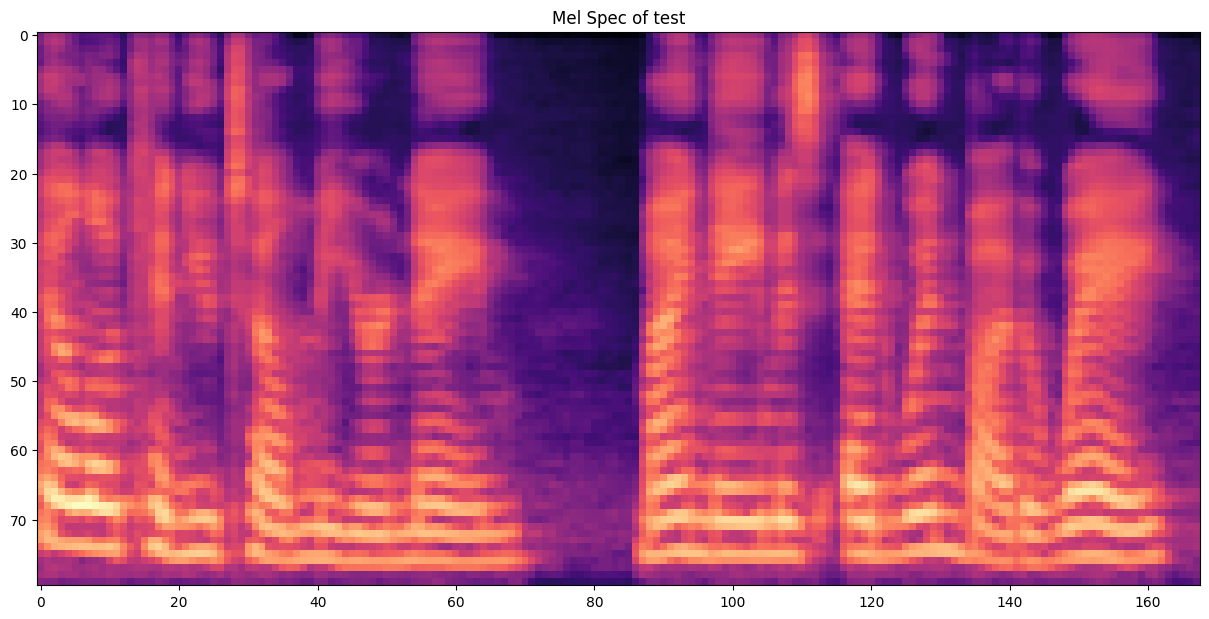

In [51]:
# Display our mel spec from our generated audio
y, sr = librosa.load('test.wav')
spec = librosa.feature.melspectrogram(
    y=y, sr=sr,
    n_fft=2048,
    hop_length=512,
    win_length=None,
    window='hann',
    center=True,
    pad_mode='reflect',
    power=2.0,
    n_mels=80
)

plt.figure(figsize=(15, 10))
plt.title('Mel Spec of test')
plt.imshow(np.log(spec)[::-1], cmap='magma')

# Text Classification
- Lets do text classification next
- We can use bert to classifiy some text

In [52]:
from nemo.collections.nlp.models.text_classification import TextClassificationModel
import wget
import os
from omegaconf import OmegaConf

In [53]:
def get_config():
  MODEL_CONFIG = "text_classification_config.yaml"
  CONFIG_DIR =  './configs/'
  os.makedirs(CONFIG_DIR, exist_ok=True)
  if not os.path.exists(CONFIG_DIR + MODEL_CONFIG):
      print('Downloading config file...')
      wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/nlp/text_classification/conf/' + MODEL_CONFIG, CONFIG_DIR)
      print('Config file downloaded!')
  else:
      print ('config file already exists')

  return f'./configs/{MODEL_CONFIG}'

In [54]:
config_path = get_config()
config = OmegaConf.load(config_path)
config.model.language_model.pretrained_model_name = "bert-base-uncased"
config.model.dataset.num_classes=2

model = TextClassificationModel(cfg=config.model)

Config file downloaded!
[NeMo I 2023-07-24 16:33:58 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: None, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2023-07-24 16:34:00 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.


[NeMo I 2023-07-24 16:34:00 text_classification_model:167] Dataloader config or file_path for the train is missing, so no data loader for test is created!
[NeMo I 2023-07-24 16:34:00 text_classification_model:184] Dataloader config or file_path for the validation is missing, so no data loader for test is created!
[NeMo I 2023-07-24 16:34:00 text_classification_model:193] Dataloader config or file_path for the test is missing, so no data loader for test is created!


[NeMo W 2023-07-24 16:34:00 nlp_overrides:253] Apex was not found. Please see the NeMo README for installation instructions: https://github.com/NVIDIA/apex
    Megatron-based models require Apex to function correctly.


In [56]:
queries = ['by the end of no such thing the audience , like beatrice , has a watchful affection for the monster .',
      'director rob marshall went out gunning to make a great one .',
      'uneasy mishmash of styles and genres .']

labels = ['negative', 'positive']
# max_seq_length=512 is the maximum length BERT supports.
with torch.no_grad():
  results = model.classifytext(queries=queries, batch_size=3, max_seq_length=512)
for res, qu in zip(results, queries):
  print('Query: {}, Label: {}'.format(qu, labels[res]))

[NeMo W 2023-07-24 16:36:34 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
      warnings.warn(_create_warning_msg(
    
[NeMo W 2023-07-24 16:36:35 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/collections/nlp/data/text_classification/text_classification_dataset.py:203: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
      torch.LongTensor(padded_input_ids),
  

Query: by the end of no such thing the audience , like beatrice , has a watchful affection for the monster ., Label: positive
Query: director rob marshall went out gunning to make a great one ., Label: positive
Query: uneasy mishmash of styles and genres ., Label: positive


# Token Classification
- Lets but not least last test out named entity recoginition
- We can use bert for the same purpose

In [57]:
from nemo.collections import nlp as nemo_nlp

In [58]:
pretrained_ner_model = nemo_nlp.models.TokenClassificationModel.from_pretrained(model_name="ner_en_bert")

[NeMo I 2023-07-24 16:39:40 cloud:68] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/ner_en_bert/versions/1.10/files/ner_en_bert.nemo to /root/.cache/torch/NeMo/NeMo_1.20.0rc0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo
[NeMo I 2023-07-24 16:39:58 common:913] Instantiating model from pre-trained checkpoint
[NeMo I 2023-07-24 16:40:05 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: bert-base-uncased, vocab_file: /tmp/tmphj2b3vxs/tokenizer.vocab_file, merges_files: None, special_tokens_dict: {}, and use_fast: False


Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2023-07-24 16:40:06 modelPT:244] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.
[NeMo W 2023-07-24 16:40:06 modelPT:161] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    text_file: text_train.txt
    labels_file: labels_train.txt
    shuffle: true
    num_samples: -1
    batch_size: 64
    
[NeMo W 2023-07-24 16:40:06 modelPT:168] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    text_file: text_dev.txt
    labels_file: labels_dev.txt
    shuffle: false
    num_samples: -1
    batch_size: 64
    

[NeMo I 2023-07-24 16:40:11 save_restore_connector:249] Model TokenClassificationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.20.0rc0/ner_en_bert/8186f86c83b11d70b43b9ead695e7eda/ner_en_bert.nemo.


In [66]:
# define the list of queries for inference
queries = [
    'we bought four shirts from the nvidia gear store in santa clara.',
    'Nvidia is a company.',
    'The Adventures of Tom Sawyer by Mark Twain is an 1876 novel about a young boy growing '
    + 'up along the Mississippi River.',
]
results = pretrained_ner_model.add_predictions(queries)

for index, (query, result) in enumerate(zip(queries, results)):
  if index == 0:
    print(f'\n=======Results=======\nQuery : {query}')
  else:
    print(f'Query : {query}')

  if index == len(queries) - 1:
    print(f'Result: {result.strip()}')
  else:
    print(f'Result: {result.strip()}\n')

[NeMo I 2023-07-24 16:46:02 token_classification_dataset:123] Setting Max Seq length to: 25
[NeMo I 2023-07-24 16:46:02 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2023-07-24 16:46:02 data_preprocessing:406] Min: 9 |                  Max: 25 |                  Mean: 17.0 |                  Median: 17.0
[NeMo I 2023-07-24 16:46:02 data_preprocessing:412] 75 percentile: 21.00
[NeMo I 2023-07-24 16:46:03 data_preprocessing:413] 99 percentile: 24.84


[NeMo W 2023-07-24 16:46:03 token_classification_dataset:152] 0 are longer than 25


[NeMo I 2023-07-24 16:46:03 token_classification_dataset:155] *** Example ***
[NeMo I 2023-07-24 16:46:03 token_classification_dataset:156] i: 0
[NeMo I 2023-07-24 16:46:03 token_classification_dataset:157] subtokens: [CLS] we bought four shirts from the n ##vid ##ia gear store in santa clara . [SEP]
[NeMo I 2023-07-24 16:46:03 token_classification_dataset:158] loss_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
[NeMo I 2023-07-24 16:46:03 token_classification_dataset:159] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
[NeMo I 2023-07-24 16:46:03 token_classification_dataset:160] subtokens_mask: 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0

=======Results=======
Query : we bought four shirts from the nvidia gear store in santa clara.
Result: we bought four shirts from the nvidia[B-ORG] gear store in santa[B-LOC] clara[I-LOC].

Query : Nvidia is a company.
Result: Nvidia[B-ORG] is a company.

Query : The Adventures of Tom Sawyer by Mark Twain is an 1876 nove

# Export model to onnx
- Finally lets export all of our models to onnx
- Onnx is model format thats more suitble for inference

In [67]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [68]:
import os
import onnxruntime as ort

In [71]:
outdir = "onnx/"
if not os.path.exists(outdir):
  os.makedirs(outdir)
quart_name = 'quartnet.onnx'
bert_name = 'bert_ner.onnx'

In [72]:
print('Exporting ONNX model')
quartz_export_path = os.path.join(outdir, quart_name)
quartznet.export(quartz_export_path)

bert_export_path = os.path.join(outdir, bert_name)
pretrained_ner_model.export(bert_export_path)

[NeMo W 2023-07-24 16:48:51 conv_asr:73] Turned off 170 masked convolutions


Exporting ONNX model


[NeMo W 2023-07-24 16:49:08 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input audio_signal
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:08 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input length
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:08 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input logprobs
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:09 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/nemo/coll

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[NeMo I 2023-07-24 16:49:35 exportable:130] Successfully exported EncDecCTCModel to onnx/quartnet.onnx


[NeMo W 2023-07-24 16:49:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input_ids
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input attention_mask
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:36 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:2033: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input token_type_ids
      warnings.warn(
    
[NeMo W 2023-07-24 16:49:36 nemo_logging:349] /usr/local/lib/python3.10/dist-package

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[NeMo I 2023-07-24 16:49:49 exportable:130] Successfully exported TokenClassificationModel to onnx/bert_ner.onnx


(['onnx/bert_ner.onnx'],
 ['nemo.collections.nlp.models.token_classification.token_classification_model.TokenClassificationModel exported to ExportFormat.ONNX'])

In [73]:
quartz_sess = ort.InferenceSession(quartz_export_path)

In [74]:
bert_sess = ort.InferenceSession(bert_export_path)